Diffusion at time: 38.40 mS, 71.22 mS, 124.41 mS, 187.78 mS
Position x: 853.35, 1582.76, 2764.62, 4173.00
Speed: 2.22e+04
imax 200.33096969696962
Diffusuion constant: 4253 μmˆ2
Radius: 0.0505 nm


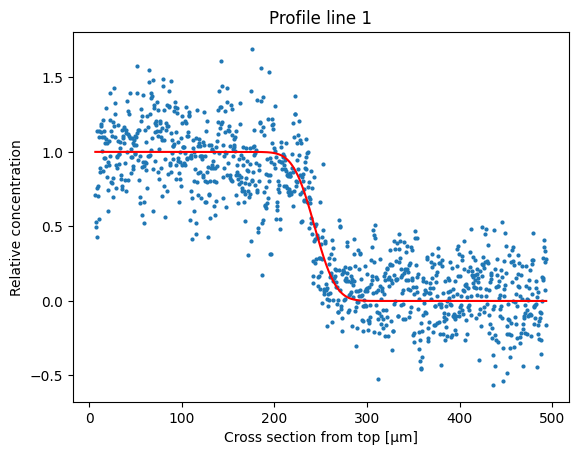

imax 202.65450707070704
Diffusuion constant: 8512 μmˆ2
Radius: 0.0252 nm


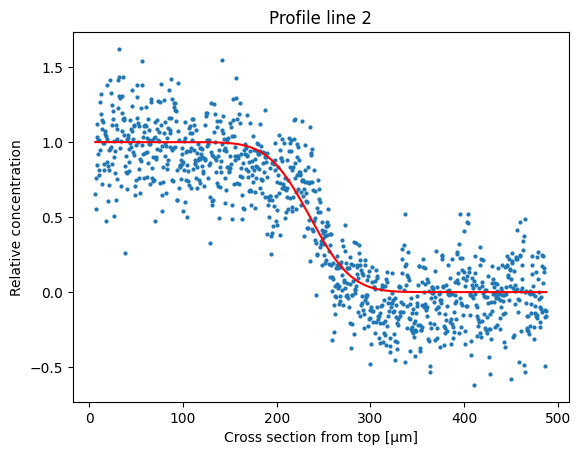

imax 203.17156262626258
Diffusuion constant: 4619 μmˆ2
Radius: 0.0465 nm


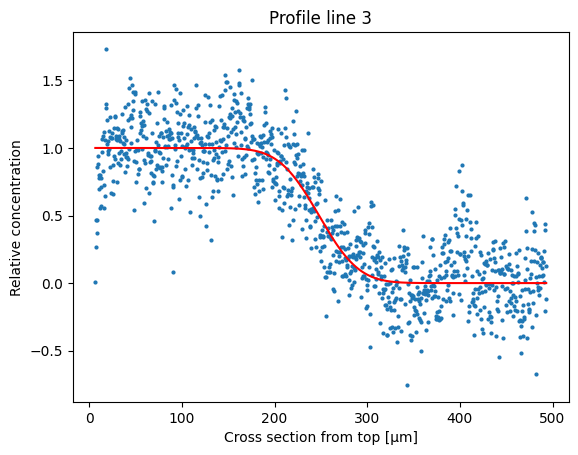

imax 202.48562828282832
Diffusuion constant: 2191 μmˆ2
Radius: 0.0979 nm


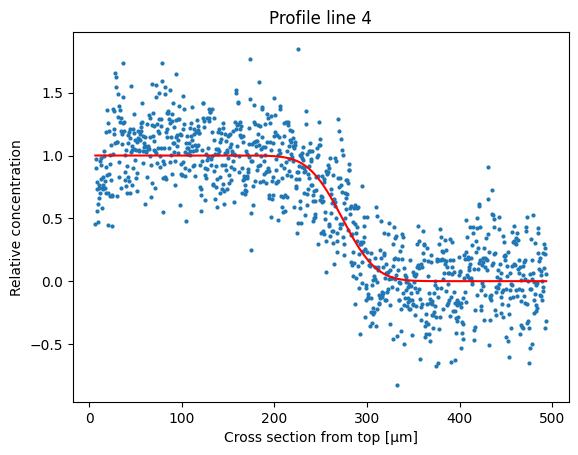

In [32]:
# Part B: Microfluidics, nm sized particles
# Relative Concentration Profiles and Hydrodynamic Radius from Mean Squared Displacement for the Particles
import matplotlib.pyplot as plt
from scipy.special import erf
import numpy as np
import csv
import pandas as pd
from scipy.optimize import curve_fit

# Import the data from CSV files
data_line_1 = pd.read_csv('Values_method_1.csv', encoding='ISO-8859-1')
data_line_2 = pd.read_csv('Values_method_2.csv', encoding='ISO-8859-1')
data_line_3 = pd.read_csv('Values_method_3.csv', encoding='ISO-8859-1')
data_line_4 = pd.read_csv('Values_method_4.csv', encoding='ISO-8859-1')

data_line_1 = data_line_1.iloc[15:-15]
data_line_2 = data_line_2.iloc[15:-15]
data_line_3 = data_line_3.iloc[15:-15]
data_line_4 = data_line_4.iloc[15:-15]

# Lengths measured in ImageJ
l_1, l_2, l_3, l_4 = 853.352, 853.352+(199.642+529.765), (853.352+199.642+529.765)+(600.763+581.094) , (853.352+199.642+529.765+600.763+581.094)+533.432+874.951

# Define physical dimensions and flow rate
width = 500  # um
depth = 75   # um
length = l_4  # um
flowrate = 50 / 60  # From uL/min to uL/s
flowrate_um3 = flowrate * 1e9  # Convert to µm³/s
um_s = flowrate_um3 / (width * depth) #velocity µm/s
v = 1e-3 * 1e-6 # viscosity µPa*s
T = 293   # Kelvin, 20 degrees Celsius in lab
k_b = 1.3806505e-23 * 1e12 # µ J/K

# Diffusion  at time: t = l / v 
t_1, t_2, t_3, t_4 = (l_1 / um_s), (l_2 / um_s), (l_3 / um_s), (l_4 / um_s)


print(f'Diffusion at time: {t_1 * 1000:.2f} mS, {t_2 * 1000:.2f} mS, {t_3 * 1000:.2f} mS, {t_4 * 1000:.2f} mS')
print(f'Position x: {l_1:.2f}, {l_2:.2f}, {l_3:.2f}, {l_4:.2f}')
print(f'Speed: {um_s:.2e}')

# Transpose data from ImageJ
x_1, I_1 = data_line_1.values.T
x_2, I_2 = data_line_2.values.T
x_3, I_3 = data_line_3.values.T
x_4, I_4 = data_line_4.values.T

# Normalization function
def norm(val):
    max_val = sum(val[1:100]) / len(val[1:100])
    min_val = sum(val[-100:]) / len(val[-100:])
    return [(i - min_val) / (max_val - min_val) for i in val]

# Absorbance function
def A(I,I_max):
    return np.log10(I/I_max)

# Diffusion to hydrodynamic radius conversion using Stokes-Einstein equation # to find the radius based on D
def SE(D):
    return (k_b * T) / (6 * np.pi * v * D)

I_list = [I_1,I_2,I_3,I_4]
x_list = [x_1,x_2,x_3,x_4] 
t_list = [t_1,t_2,t_3,t_4]
x_0_list = [0,0,0,0]
D_list = [0,0,0,0]     #saved as mˆ2/s
for i in range(4): # Line i data processing
    # Define Fick's law model for each diffusion time
    c_0 = 0.5     #initial consentration???
    ficks = lambda x, x_0, D: c_0 * (1 - erf((x - x_0)/ np.sqrt(4 * D * t_list[i])))
    I_max = sum(I_list[i][1:100]) / len(I_list[i][1:100])
    A_new = [A(j,I_max) for j in I_list[i]]
    print('imax',I_max)
    
    popt, pcov = curve_fit(ficks, x_list[i], norm(A_new),p0=(100, 100))
    x_0_list[i], D_list[i] = popt

    print(f'Diffusuion constant: {D_list[i]:.0f} \u03BCmˆ2')
    print(f'Radius: {SE(D_list[i])*1e3:.3} nm')
    
    plt.plot(x_list[i], ficks(x_list[i], *popt), 'r', label='fit: x_0=%500f, D=%500f' % tuple(popt))
    plt.scatter(x_list[i], norm(A_new), s=4)
    plt.xlabel('Cross section from top [\u03BCm]')
    plt.ylabel('Relative concentration')
    plt.title(f'Profile line {i+1}')
    plt.show()

Mean diffusion coefficient: 4894| Standard deviation: 2285
Radius from average diffusion coefficient: 0.044 nm | std for radius: 0.027 nm
Radius for D - std: 8.23e-05um
Radius for D + std: 2.99e-05um


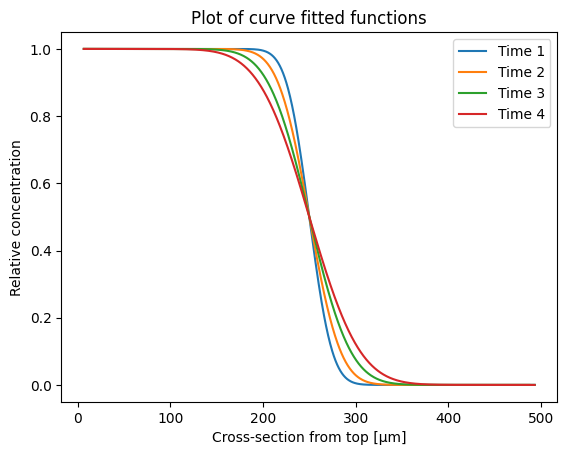

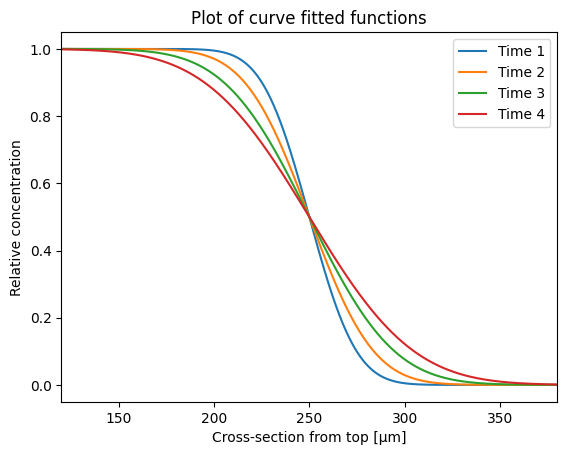

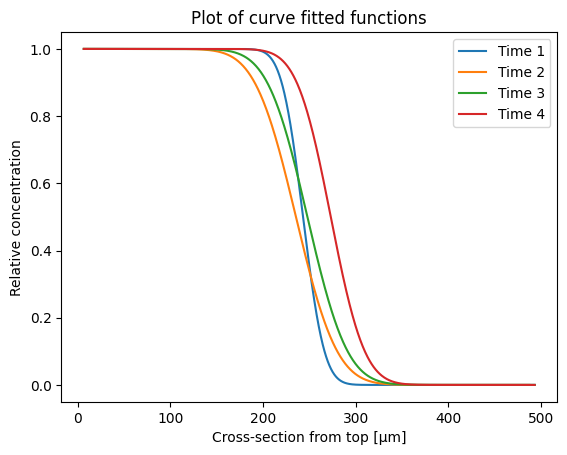

In [33]:
# Calculate and display diffusion coefficients and hydrodynamic radii
D_list =  np.array(D_list) # now umˆ2/s
D_mean = np.mean(D_list)
std = np.std(D_list)
x_0_mean = np.mean(x_0_list)
r_values = SE(D_list)#[SE(i) for i in D_list]

print(f'Mean diffusion coefficient: {D_mean:.0f}| Standard deviation: {std:.0f}')
print(f'Radius from average diffusion coefficient: {SE(D_mean)*1e3:.2} nm | std for radius: {np.std(np.array(r_values)*1e3):.2} nm')
print(f'Radius for D - std: {SE(D_mean - std):.2e}um')
print(f'Radius for D + std: {SE(D_mean + std):.2e}um')


ficks = lambda x, x_0, D,t: c_0 * (1 - erf((x - x_0)/ np.sqrt(4 * D * t)))
# Plot curve-fitted functions for all lines where they have average D and x_0
plt.plot(x_list[0], ficks(x_list[0],x_0_mean,D_mean,t_list[0]), label='Time 1')
plt.plot(x_list[1], ficks(x_list[1],x_0_mean,D_mean,t_list[1]), label='Time 2')
plt.plot(x_list[2], ficks(x_list[2],x_0_mean,D_mean,t_list[2]), label='Time 3')
plt.plot(x_list[3], ficks(x_list[3],x_0_mean,D_mean,t_list[3]), label='Time 4')
plt.xlabel('Cross-section from top [\u03BCm]')
plt.ylabel('Relative concentration')
plt.title('Plot of curve fitted functions')
plt.legend()
plt.show()

# Plot curve-fitted functions for all lines where they have average D and x_0; 
#ZOOM INN
plt.figure()
plt.plot(x_list[0], ficks(x_list[0],x_0_mean,D_mean,t_list[0]), label='Time 1')
plt.plot(x_list[1], ficks(x_list[1],x_0_mean,D_mean,t_list[1]), label='Time 2')
plt.plot(x_list[2], ficks(x_list[2],x_0_mean,D_mean,t_list[2]), label='Time 3')
plt.plot(x_list[3], ficks(x_list[3],x_0_mean,D_mean,t_list[3]), label='Time 4')
plt.xlim(120,380)
plt.xlabel('Cross-section from top [\u03BCm]')
plt.ylabel('Relative concentration')
plt.title('Plot of curve fitted functions')
plt.legend()
plt.show()

# Plot curve-fitted functions for all lines where they dont have average D and x_0
plt.figure()
plt.plot(x_list[0], ficks(x_list[0],x_0_list[0],D_list[0],t_list[0]), label='Time 1')
plt.plot(x_list[1], ficks(x_list[1],x_0_list[1],D_list[1],t_list[1]), label='Time 2')
plt.plot(x_list[2], ficks(x_list[2],x_0_list[2],D_list[2],t_list[2]), label='Time 3')
plt.plot(x_list[3], ficks(x_list[3],x_0_list[3],D_list[3],t_list[3]), label='Time 4')
plt.xlabel('Cross-section from top [\u03BCm]')
plt.ylabel('Relative concentration')
plt.title('Plot of curve fitted functions')
plt.legend()
plt.show()